In [2]:
from pycbc import distributions
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt
import numpy as np
import pylab
from tqdm.notebook import tqdm
from gwpy.timeseries import TimeSeries
import pandas as pd
import os
import csv
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from pycbc.catalog import Merger
import pylab
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.psd
import pycbc.noise

/usr/local/lib/python3.8/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
directory = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/"

In [3]:
bbh_events = ['GW150914',
              'GW151012',
              'GW151226',
              'GW170104',
              'GW170608',
              'GW170729',
              'GW170809',
              'GW170814',
              'GW170818',
              'GW170823',
              'GW190408_181802',
              'GW190412',              
              'GW190413_052954',
              'GW190413_134308',
              'GW190421_213856',
              'GW190424_180648',
              'GW190425',
              'GW190503_185404',
              'GW190512_180714',
              'GW190513_205428',
              'GW190514_065416',
              'GW190517_055101',
              'GW190519_153544',
              'GW190521',
              'GW190521_074359',
              'GW190527_092055',
              'GW190602_175927',
              'GW190620_030421',
              'GW190630_185205',
              'GW190701_203306',
              'GW190706_222641',
              'GW190707_093326',
              'GW190708_232457',
              'GW190719_215514',
              'GW190720_000836',
              'GW190727_060333',
              'GW190728_064510',
              'GW190731_140936',
              'GW190803_022701',
              'GW190814',
              'GW190828_063405',
              'GW190828_065509',
              'GW190909_114149',
              'GW190910_112807',
              'GW190915_235702',
              'GW190924_021846',
              'GW190929_012149',
              'GW190930_133541']

In [4]:
#fetching strain data from gwosc server
output_dir = os.path.join(directory, "BBH/original-signals/")
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    start = int(gps) - 15
    end = int(gps) + 15

    data = TimeSeries.fetch_open_data('L1', start, end)
    data.write(os.path.join(output_dir, bbh_events[i] + ".txt"))

  0%|          | 0/48 [00:00<?, ?it/s]

In [7]:
    #Merging the signal
    input_dir = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/original-signals/"
    output_csv = os.path.join("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/", "Original_BBH.csv")
    os.makedirs(input_dir, exist_ok=True)
    files = os.listdir(input_dir)
    f = open(output_csv , 'w')
    cw = csv.writer(f)
    
    for i in tqdm(files):
        df = pd.read_csv(input_dir+i,sep = ' ', header=None)
        c = df[:][1]
        cw.writerow(c)
    f.close()

  0%|          | 0/48 [00:00<?, ?it/s]

In [9]:
#chatgpt code
import os
import pandas as pd
import csv
from tqdm import tqdm

input_dir = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/original-signals/"
output_csv = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/original-signals/Original_BBH.csv"

files = os.listdir(input_dir)
with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    for filename in tqdm(files):
        df = pd.read_csv(os.path.join(input_dir, filename), sep=' ', comment='#', header=None)

        # === Safely grab the last column (usually strain) ===
        strain = df.iloc[:, -1].values  # this avoids selecting empty/malformed column

        # === Make sure it's 16384 samples (4 sec at 4096Hz) ===
        strain = strain[:16384] if len(strain) >= 16384 else np.pad(strain, (0, 16384 - len(strain)), 'constant')

        writer.writerow(strain)


100%|██████████| 49/49 [00:07<00:00,  6.53it/s]


In [59]:
#processing the strain data
#why whitening?
#Think of it as normalizing the signal in the frequency domain to remove colored noise.
#Removes frequency-dependent power (noise features) from the strain
#Makes the power spectral density (PSD) flat across frequency
#Helps expose the hidden GW signal in noisy data
output_dir = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/processed-signals/"
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(len(bbh_events))):
    gps = event_gps(bbh_events[i])
    data = TimeSeries.read(input_dir + bbh_events[i]+".txt")
    data = TimeSeries.to_pycbc(data)
    data = data.whiten(4,4)
    data = data.highpass_fir(30, 512).lowpass_fir(250, 512)
    data = data. time_slice(gps-2, gps + 2)

    data = TimeSeries.from_pycbc(data)
    data.write(os.path.join(output_dir, bbh_events[i] + ".txt"))

  0%|          | 0/48 [00:00<?, ?it/s]

In [67]:
input_dir =  "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/processed-signals/"
output_dir = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/"
output_csv = os.path.join(output_dir, "Processed_BBH.csv")
os.makedirs(input_dir, exist_ok=True)
files = os.listdir(input_dir)
f = open(output_csv , 'w')
cw = csv.writer(f)

try:
    for i in tqdm(files):
        df = pd.read_csv(input_dir+i,sep = ' ', header=None)
        c = df[:][1]
        cw.writerow(c)
    f.close()
except:
    print(f"❌ Error processing file: {file}")

  0%|          | 0/48 [00:00<?, ?it/s]

4096.0 Hz


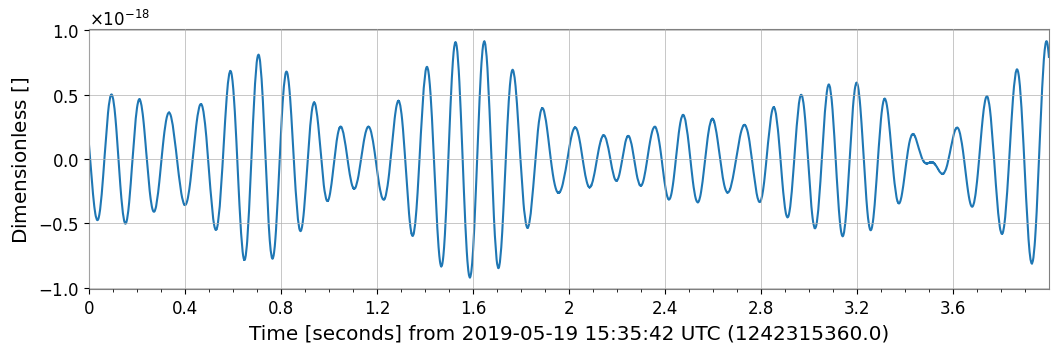

In [68]:
gps = event_gps("GW190519_153544")
start = int(gps) - 2
end = int(gps) + 2
data = TimeSeries.fetch_open_data('L1', start, end)
data.plot()
print(data.sample_rate)

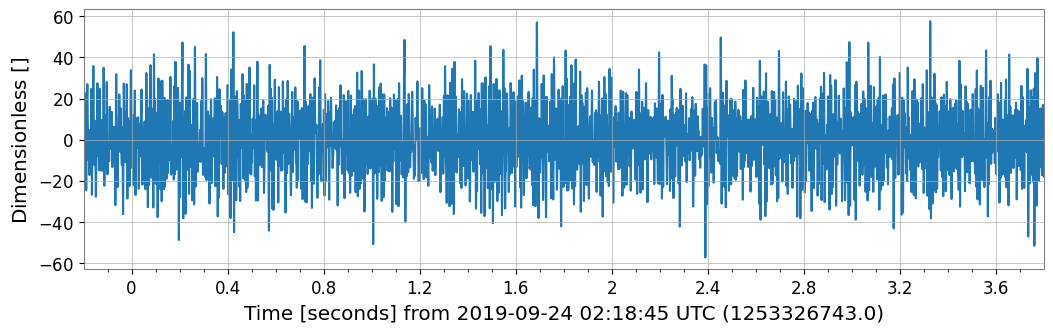

In [73]:
i = 45
data1 = TimeSeries.read("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/processed-signals/"+bbh_events[i]+".txt")
fig = data1.plot()
fig.show()

BNS Merger Strain Data Download


In [75]:
bns_events = ['GW170817', 'GW190425']
output_dir = os.path.join("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BNS/original-signals/")
os.makedirs(output_dir, exist_ok=True)

In [76]:
for i in tqdm(range(len(bns_events))):

    gps = event_gps(bns_events[i])
    start = int(gps) - 15
    end = int(gps) + 15

    data = TimeSeries.fetch_open_data('L1', start, end)

    data.write("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BNS/original-signals/"+bns_events[i]+".txt") 

  0%|          | 0/2 [00:00<?, ?it/s]

In [77]:
path = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BNS/original-signals/"
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BNS/" + 'Original_BNS.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

  0%|          | 0/2 [00:00<?, ?it/s]

In [79]:
output_dir = os.path.join("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BNS/processed-signals/")
os.makedirs(output_dir, exist_ok=True)
for i in tqdm(range(len(bns_events))):
    gps = event_gps(bns_events[i])
    
    data = TimeSeries.read(path+bns_events[i]+".txt")    
    data = TimeSeries.to_pycbc(data)
    data = data.whiten(4, 4)
    data = data.highpass_fir(30, 512).lowpass_fir(250, 512)
    data = data.time_slice(gps - 2, gps + 2)
    
    data = TimeSeries.from_pycbc(data)
    data.write(output_dir+bns_events[i]+".txt")

  0%|          | 0/2 [00:00<?, ?it/s]

In [80]:
path = output_dir
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BNS/" + 'Processed_BNS.csv', 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

  0%|          | 0/2 [00:00<?, ?it/s]

4096.0 Hz


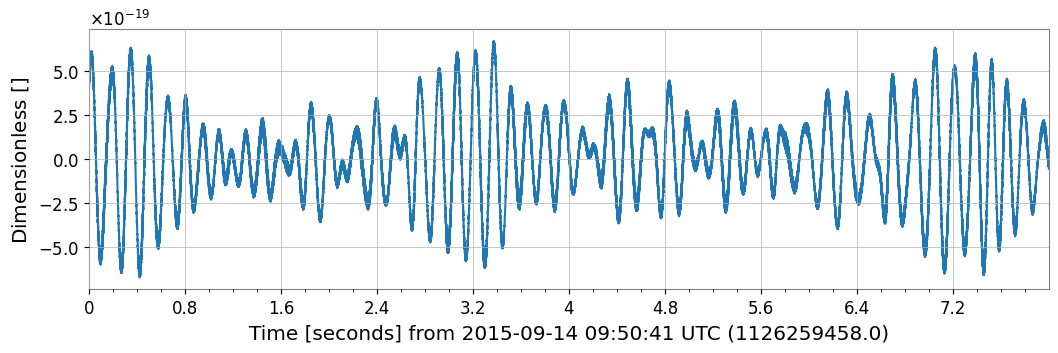

In [81]:
gps = event_gps("GW150914")
start = int(gps) - 4
end = int(gps) + 4
data = TimeSeries.fetch_open_data('H1', start, end)
data.plot()
print(data.sample_rate)

Extra Noise Samples

In [3]:
output_dir = os.path.join("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/Noise")
os.makedirs(output_dir, exist_ok=True)
#generating 24 noise samples
for i in tqdm(range(24)):
    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    # Generate 4 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(4 / delta_t)
    noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd)

    noise = TimeSeries.from_pycbc(noise)

    noise.write("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/" + "/Noise/noise_"+str(i)+".txt")

  0%|          | 0/24 [00:00<?, ?it/s]

In [4]:
path = "C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/Noise/"
files= os.listdir(path)
f = open("C:/Users/sunda/Documents/Github/Gravitational Wave Detection/scripts/LIGO-detector-data/BBH/Noise.csv", 'w')
cw = csv.writer(f)

for i in tqdm(files):
    df = pd.read_csv(path+i,sep = ' ', header=None)
    c = df[:][1]
    cw.writerow(c)
f.close()

  0%|          | 0/24 [00:00<?, ?it/s]

1126259462.4


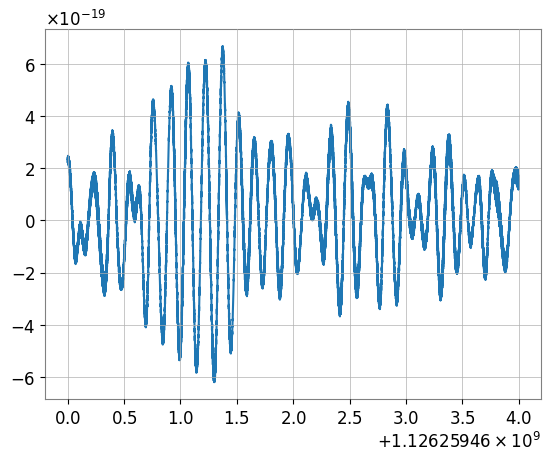

In [86]:
gps = event_gps("GW150914")
print(gps)
start = int(gps) - 2
end = int(gps) + 2

data = TimeSeries.fetch_open_data('H1', start, end)
plt.plot(data)